In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

/home/lucas/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Vamos carregar os dados extraídos do PCA no notebook 1

In [2]:
# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
try:
    # Carregar dados
    X_scaled = np.load('../data/features/X_scaled_agregado.npy', allow_pickle=True)
    feature_names = np.load('../data/features/feature_names_agregado.npy', allow_pickle=True)
    player_names = np.load('../data/features/player_names.npy', allow_pickle=True)
    df_agregado = pd.read_csv('../data/processed_data/dados_processados_agregados.csv')
    
    print(f"✓ Dados carregados: {X_scaled.shape[0]} jogadores, {X_scaled.shape[1]} features")
except FileNotFoundError:
    print("ERRO: Arquivos .npy ou .csv não encontrados.")
    print("Por favor, execute o Notebook 1 (com a célula de salvar) primeiro.")
    raise

✓ Dados carregados: 474 jogadores, 30 features


# Análise do K Ideal para o K-Means
## ELbow Method


[1] Calculando Elbow Method (Método do Cotovelo)...


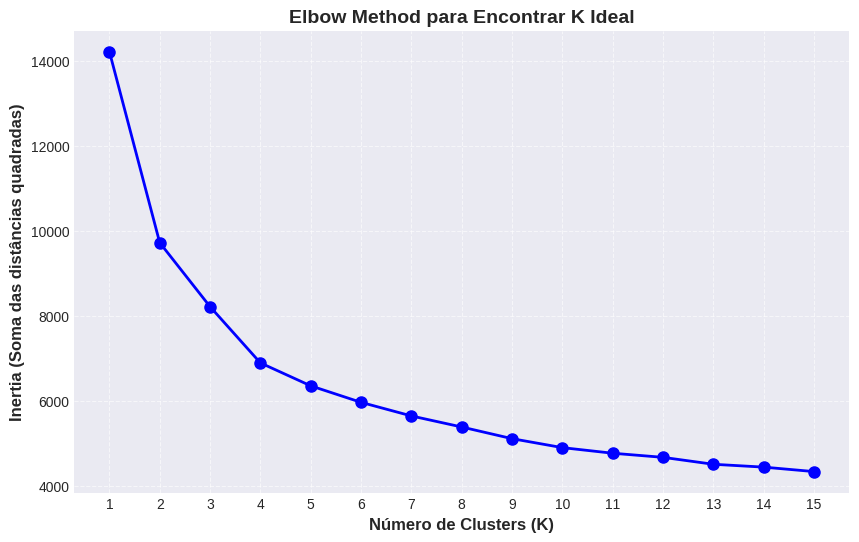

✓ Gráfico salvo: 02_kmeans_elbow_method.png


In [4]:
print("\n[1] Calculando Elbow Method (Método do Cotovelo)...")
inertia = []
K_range = range(1, 16) # Testar de 1 a 15 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
plt.ylabel('Inertia (Soma das distâncias quadradas)', fontsize=12, fontweight='bold')
plt.title('Elbow Method para Encontrar K Ideal', fontsize=14, fontweight='bold')
plt.xticks(K_range)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('../images/02_kmeans_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Gráfico salvo: 02_kmeans_elbow_method.png")

### Silhouette Score


[2] Calculando Silhouette Score (Pontuação da Silhueta)...


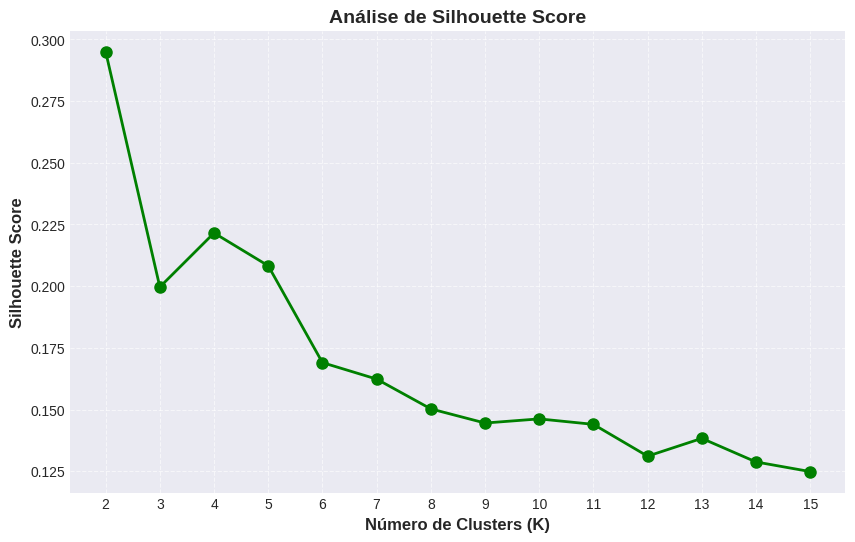

✓ Gráfico salvo: 02_kmeans_silhouette_score.png


In [5]:
print("\n[2] Calculando Silhouette Score (Pontuação da Silhueta)...")
silhouette_scores = []
# K=1 não é válido para silhouette score
K_range_silhouette = range(2, 16) 

for k in K_range_silhouette:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plotar o gráfico da silhueta
plt.figure(figsize=(10, 6))
plt.plot(K_range_silhouette, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=12, fontweight='bold')
plt.title('Análise de Silhouette Score', fontsize=14, fontweight='bold')
plt.xticks(K_range_silhouette)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('../images/02_kmeans_silhouette_score.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Gráfico salvo: 02_kmeans_silhouette_score.png")

## Conclusão da análise
- Com base no que ambos os gráficos apresentaram, o valor de K ideal seria 4, pois é o ponto onde temos o cotovelo e uma silhouette score mais alta do que o ponto 5. Mas poderíamos utilizá-lo também, pois é um bom ponto bom, mas não o ótimo.

In [6]:
K_IDEAL = 4 
print(f"\n[3] Aplicando K-means com K={K_IDEAL}...")

kmeans = KMeans(n_clusters=K_IDEAL, init='k-means++', n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Adicionar labels ao DataFrame
df_agregado['Cluster'] = cluster_labels
print(f"✓ Clusterização concluída. Distribuição dos clusters:")
print(df_agregado['Cluster'].value_counts().sort_index())


[3] Aplicando K-means com K=4...
✓ Clusterização concluída. Distribuição dos clusters:
Cluster
0    155
1    177
2     89
3     53
Name: count, dtype: int64



[4] Analisando e Visualizando os Clusters...


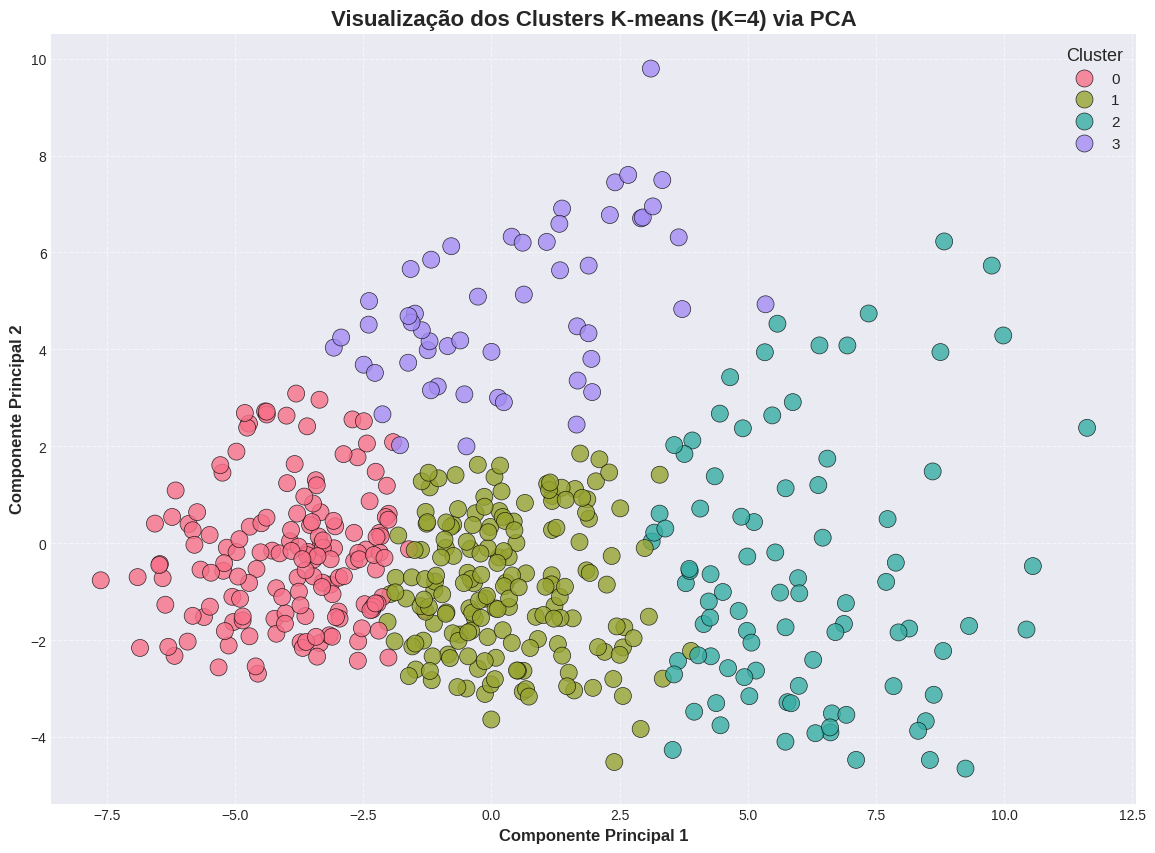

✓ Gráfico salvo: 02_kmeans_cluster_visualization.png


In [7]:
print("\n[4] Analisando e Visualizando os Clusters...")

# Para visualizar, usamos PCA (do Notebook 1) para reduzir para 2D
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_scaled)

# Plotar os clusters em 2D
plt.figure(figsize=(14, 10))
palette = sns.color_palette("husl", K_IDEAL)
sns.scatterplot(
    x=X_pca_2d[:, 0], 
    y=X_pca_2d[:, 1],
    hue=cluster_labels,
    palette=palette,
    s=150,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)
plt.title(f'Visualização dos Clusters K-means (K={K_IDEAL}) via PCA', fontsize=16, fontweight='bold')
plt.xlabel('Componente Principal 1', fontsize=12, fontweight='bold')
plt.ylabel('Componente Principal 2', fontsize=12, fontweight='bold')
plt.legend(title='Cluster', loc='best', fontsize=11, title_fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('../images/02_kmeans_cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Gráfico salvo: 02_kmeans_cluster_visualization.png")

In [ ]:
print("\n[5] Gerando perfis dos clusters...")

# Selecionar apenas colunas numéricas para a média
numeric_cols = df_agregado.select_dtypes(include=[np.number]).columns
# Excluir 'Games' e 'Cluster' da análise de perfil, se desejar
cols_para_perfil = [col for col in numeric_cols if col not in ['Games']]

# Calcular a média das estatísticas para cada cluster
df_perfis = df_agregado.groupby('Cluster')[cols_para_perfil].mean().T

# Adicionar a média geral para comparação
df_perfis['Media_Geral'] = df_agregado[cols_para_perfil].mean().T

# Salvar perfis em CSV
df_perfis.to_csv('../data/processed_data/02_kmeans_perfis_clusters.csv')
print("✓ Perfis dos clusters salvos em: 02_kmeans_perfis_clusters.csv")

# Salvar DataFrame final com jogadores e seus clusters
df_jogadores_clusters = df_agregado[['Player', 'Tm', 'Games', 'PTS', 'TRB', 'AST', 'Cluster']].copy()
df_jogadores_clusters.sort_values(by=['Cluster', 'PTS'], ascending=[True, False], inplace=True)
df_jogadores_clusters.to_csv('../data/processed_data/02_jogadores_e_clusters.csv', index=False)
print("✓ Lista de jogadores com clusters salva em: 02_jogadores_e_clusters.csv")


[5] Gerando perfis dos clusters...
✓ Perfis dos clusters salvos em: 02_kmeans_perfis_clusters.csv
✓ Lista de jogadores com clusters salva em: 02_jogadores_e_clusters.csv


## Analisando os cluster formados
#### Cluster 0
- O que podemos observar é que os joggadores do grupo 0 apresentam a menor média de pontuação, menor participação defensiva com rebotes e menor participação no 'playmaking'.
Ou seja, são **bench warmers** ou jogadores com pouca relevância na liga.
---
#### Cluster 1
- No cluster 1, já temos jogadores com uma média de pontuação acima de 10, com uma relativa participação defensiva relacionada aos rebotes por jogo e uma baixa participação ofensiva na questão de organização das jogadas também. Mas já são jogadores **role-players** que desempenham bem e contribuem efetivamente para suas franquias, pontuando bem.
---
#### Cluster 2
- No cluster 2 temos os **GOATs** da temporada, jogadores com os melhores números, média de pontuação acima dos 20 pontos, alguns com alta participação defensiva com médias superiores a 10 rebotes por jogo e alta taxa de assistências. 
- São jogadores que causam um grande impacto nas partidas, são os 89 melhores jogadores da NBA.
---
### Cluster 3
- Cluster dos pivôs, jogadores com alta média de rebotes e uma pontuação até que considerável, mas seu destaque é para o impacto defensivo.